<a href="https://colab.research.google.com/github/c-mertes/RNAseq-ASHG19/blob/master/colab_notebooks/Expression_Outlier_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Expression Outlier Detection in RNA-seq data</h1>

A hands-on rare disease diagnostic workshop on RNA-seq data @ ASHG19

---

# Setup the notebook

To get started we have to setup this IR notebook @ Colab. To do so please run the following code snippet.
This will download all nessesary software packages for this tutorial. Also it will download the example data sets used throughout this tutorial.




In [0]:
download.file("https://raw.githubusercontent.com/c-mertes/RNAseq-ASHG19/master/r-env-setup-script.R", "r-env-setup-script.R")
source("r-env-setup-script.R")

Update and install needed Ubuntu packages
Download R package cache
Unzipping R package cache
Retrieve data for tutorials


## Install needed packages

For the following analysis we will need the [*OUTRIDER*](http://bioconductor.org/packages/release/bioc/html/OUTRIDER.html) package to call expression outlier events and we will use [*biomaRt*](http://bioconductor.org/packages/release/bioc/html/biomaRt.html) to annotated gene symbols. 

In [0]:
# BioConductor package manager
if(!requireNamespace("BiocManager", quietly=TRUE))
    install.packages("BiocManager")

# install needed packages 
packages <- c("OUTRIDER", "biomaRt")
for(p in packages)
    if(!requireNamespace(p, quietly=TRUE))
        BiocManager::install(p, Ncpus=10)


# Import data and preprocessing
---

First we have to load the *OUTRIDER* package that we will use to run the full expression outlier analysis. For efficient data handling and visualization we further load *data.table* and *ggplot2*.

In [0]:
library(OUTRIDER)
library(ggplot2)
library(data.table)

Loading required package: BiocParallel
Loading required package: GenomicFeatures
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vecto

For the gene expression outlier detection analysis, we need the raw read counts and a sample annotation. Lets load them into the session.

In [0]:
# sampe annotation and raw read counts
anno <- fread("./annotation.tsv")
cts  <- as.matrix(read.table("./outrider/raw_counts.tsv.gz"))

head(anno)
dim(anno)

head(cts[, 1:10])
dim(cts)

RNA_ID,SEX,ORIGIN,LAB,INDIVIDUAL,phase1TG,OUTRIDER_GROUP,PAIRED_END,COUNT_MODE,COUNT_OVERLAP,COUNT_AS_STRANDED
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<lgl>,<chr>,<lgl>,<chr>
HG00096.1.M_111124_6,male,British,UNIGE,HG00096,1,all,TRUE,IntersectionStrict,TRUE,no
HG00103.4.M_120208_3,male,British,ICMB,HG00103,1,all,TRUE,IntersectionStrict,TRUE,no
HG00106.4.M_120208_5,female,British,ICMB,HG00106,1,all,TRUE,IntersectionStrict,TRUE,no
HG00111.2.M_111215_4,female,British,CNAG_CRG,HG00111,1,all,TRUE,IntersectionStrict,TRUE,no
HG00116.2.M_120131_1,male,British,CNAG_CRG,HG00116,1,all,TRUE,IntersectionStrict,TRUE,no
HG00126.1.M_111124_8,male,British,UNIGE,HG00126,1,all,TRUE,IntersectionStrict,TRUE,no


[1] 100  11

,HG00096.1.M_111124_6,HG00103.4.M_120208_3,HG00106.4.M_120208_5,HG00111.2.M_111215_4,HG00116.2.M_120131_1,HG00126.1.M_111124_8,HG00132.2.M_111215_4,HG00149.1.M_111124_6,HG00150.4.M_120208_7,HG00176.4.M_120208_2
ENSG00000000003.14_2,1,3,1,15,1,5,0,3,5,0
ENSG00000000005.5_2,0,0,0,0,0,0,0,0,0,0
ENSG00000000419.12_2,853,1131,1148,1341,863,948,1363,671,1452,1070
ENSG00000000457.13_3,413,438,510,482,385,583,547,442,504,337
ENSG00000000460.16_5,338,262,470,547,472,503,725,514,596,320
ENSG00000000938.12_2,2447,2512,3453,4113,1628,5115,2477,3000,2281,1459


[1] 60829   100

Create an *OUTRIDER* object with the loaded annotation and raw count matrix.

In [0]:
ods <- OutriderDataSet(colData=anno, countData=cts)
ods

class: OutriderDataSet
class: RangedSummarizedExperiment 
dim: 60829 100 
metadata(1): version
assays(1): counts
rownames(60829): ENSG00000000003.14_2 ENSG00000000005.5_2 ...
  ENSG00000285993.1_1 ENSG00000285994.1_1
rowData names(0):
colnames(100): HG00096.1.M_111124_6 HG00103.4.M_120208_3 ...
  NA20805.4.M_120208_7 NA20811.1.M_111124_5
colData names(11): RNA_ID SEX ... COUNT_OVERLAP COUNT_AS_STRANDED

So we can see that we have ~60.000 genes and 100 samples in our experiment (dimensions).

## Quality control and preprocessing of raw count data

Here only a view quality control metrics are explored. In a real experiment this step should be done more extensively (see slides for hints). 

First we will look at all values inside the count matrix and then the mean value by gene. This will give use an idea on how the genes are expressed.

We have to add 1 to the counts to not take the logarithm of 0. 

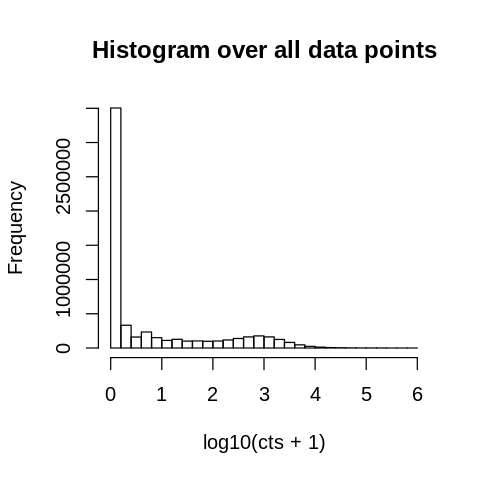

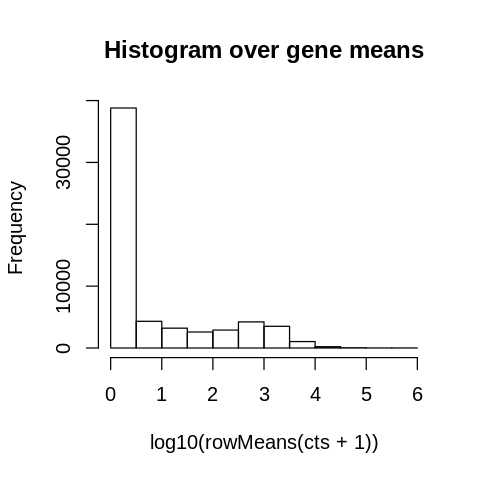

In [0]:
hist(log10(cts + 1), main = 'Histogram over all data points')
hist(log10(rowMeans(cts + 1)), main = 'Histogram over gene means')

As we can see we have a small peak around 500-1000 for expressed genes. This number depends on the experiment (sequencing depth, tissue, ...). But most of the 60.000 genes are not expressed/detected. So we have to filter them later.

In gene expression analysis the first normalization is done using the *sizeFactor*. The sizeFactor represents the sequencing depth of each sample in respect to the others and should be around 1. The sizeFactor can be estimated with `estimateSizeFactors`.

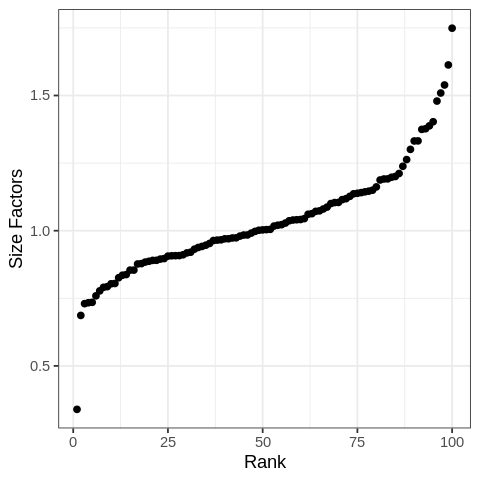

In [0]:
# estimate sizeFactors 
ods <- estimateSizeFactors(ods)

# plot the sizeFactor across the dataset
ggplot(data=NULL, aes(y=sort(sizeFactors(ods)), x=1:ncol(ods))) + geom_point() + 
labs(x='Rank', y='Size Factors') + theme_bw()

As expected most data points are around 1. A low sizeFactor indicates for a failed experiment or other issues during the preparation. Those samples should be dealed with caution.

In [0]:
sort(sizeFactors(ods))[1:5]

NA20778.4.M_120208_1 NA20805.4.M_120208_7 NA06984.1.M_111124_4 
           0.3393214            0.6866933            0.7302284 
NA20540.1.M_111124_2 HG00278.1.M_111124_5 
           0.7336435            0.7350451

## Filter non expressed genes

Not all genes are expressed in a given tissue/sample. It varies on the tissues and sequencing depth on how many expressed genes are expected. 

To make the modeling and outlier detection part more rebust a good filtering of non expressed genes is crucial. The cutoffs are dependent on the project and should be discussed beforehand.

Here, we remove genes where less then 5% of the samples have an FPKM value lower then 1.

In [0]:
# load gene annotation to compute FPKM values
txdb <- loadDb("annotations/gencode.v29lift37.annotation.txdb")
ods <- computeGeneLength(ods, txdb) # TODO bugfix why is this step needed???
ods <- filterExpression(ods, gftFile=txdb, filterGenes=FALSE)

# TODO: after OUTRIDER is reinstalled from gitlab, add the option addExpressedGenes = TRUE for plotting later


17865 genes did not passed the filter due to zero counts. This is 29.4% of the genes.
45212 genes did not passed the filter. This is 74.3% of the genes.


Number of genes filtered out and their expression distribution across all samples.

3504263 sample-gene combinations are zero. This is 57.6% of the data


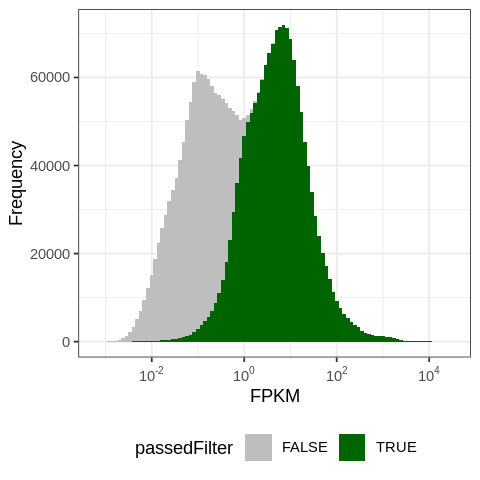

In [0]:
plotFPKM(ods) + theme_bw() + theme(legend.position = 'bottom')
# TODO: in the package add an alpha to see the gray area below

For any analysis, we should now the numbers of expressed genes per sample and globally. Lets look at this in detail. 

In [0]:
# plotExpressedGenes(ods) # only work after OUTRIDER update

Lets subset now the object to expressed genes only.

In [0]:
# filter object based on the expression status of the genes
ods <- ods[mcols(ods)[,"passedFilter"]]
ods
dim(ods)

class: OutriderDataSet
class: RangedSummarizedExperiment 
dim: 15617 100 
metadata(1): version
assays(1): counts
rownames(15617): ENSG00000000419.12_2 ENSG00000000457.13_3 ...
  ENSG00000285976.1_1 ENSG00000285979.1_1
rowData names(3): loggeomeans basepairs passedFilter
colnames(100): HG00096.1.M_111124_6 HG00103.4.M_120208_3 ...
  NA20805.4.M_120208_7 NA20811.1.M_111124_5
colData names(12): RNA_ID SEX ... COUNT_AS_STRANDED sizeFactor

[1] 15617   100

Usually in RNA-seq data one can see sample structure and hence should control for that. In most of the cases one knows the cause of the structure (eg. sex, origin, batch) but sometimes it comes from unkown confounders.

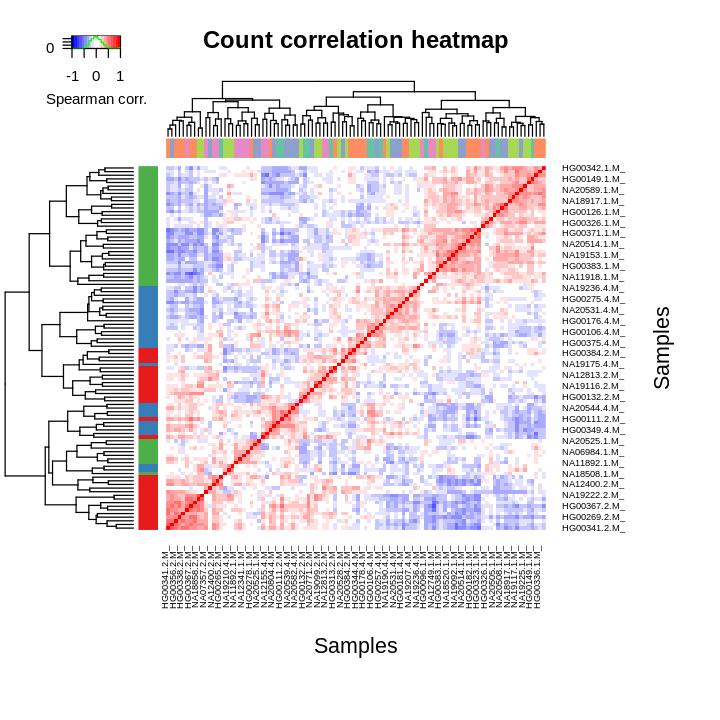

In [0]:
# Make heatmap figure bigger
options(repr.plot.width=6, repr.plot.height=6)

plotCountCorHeatmap(ods, colCoFactor="ORIGIN", rowCoFactor="LAB")

# Detection of expression outlier events

Now we have loaded the data, did some quality control and preprocessed (filtered) the data. Lets start with the outlier detection now.

## Fitting the model

We will now use *OUTRIDER* to model the latent space based on the given gene expression data.

In [0]:
ods <- OUTRIDER(ods, q=15, verbose=TRUE, 
        iterations=2, # only used here 2 iterations to speed up the tutorial
        BPPARAM=MulticoreParam(4, progressbar=TRUE))  # Takes around 2min

Fri Sep 13 09:55:07 2019: SizeFactor estimation ...
Fri Sep 13 09:55:07 2019: Controlling for confounders ...
Fri Sep 13 09:55:07 2019: Using the autoencoder implementation for controlling.


[1] "Initial PCA loss: 5.81400648686476"
  |======================================================================| 100%


CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH 
                                          15617 
[1] "Fri Sep 13 09:55:31 2019: Iteration: init D loss: 5.79646796628295"
  |======================================================================| 100%

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.0617   26.9329   77.9313  118.9771  156.5182  999.9999 
[1] "Fri Sep 13 09:55:41 2019: Iteration: init Theta loss: 5.31568525350426"
[1] "Fri Sep 13 09:56:02 2019: Iteration: 1 E loss: 5.2822431835931"
  |======================================================================| 100%


CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH 
                                          15617 
[1] "Fri Sep 13 09:56:16 2019: Iteration: 1 D loss: 5.27338196909701"
  |======================================================================| 100%

     Min.   1st Qu.    Med

Fri Sep 13 09:57:00 2019: Used the autoencoder implementation for controlling.
Fri Sep 13 09:57:00 2019: P-value calculation ...


  |======================================================================| 100%



Fri Sep 13 09:57:06 2019: Zscore calculation ...


Let's see how well the denoising autoencoder fitted the latent space of our data. Idealy we should not see any clusters anymore and most of the plot should be rather white than red or blue except the diagonal.

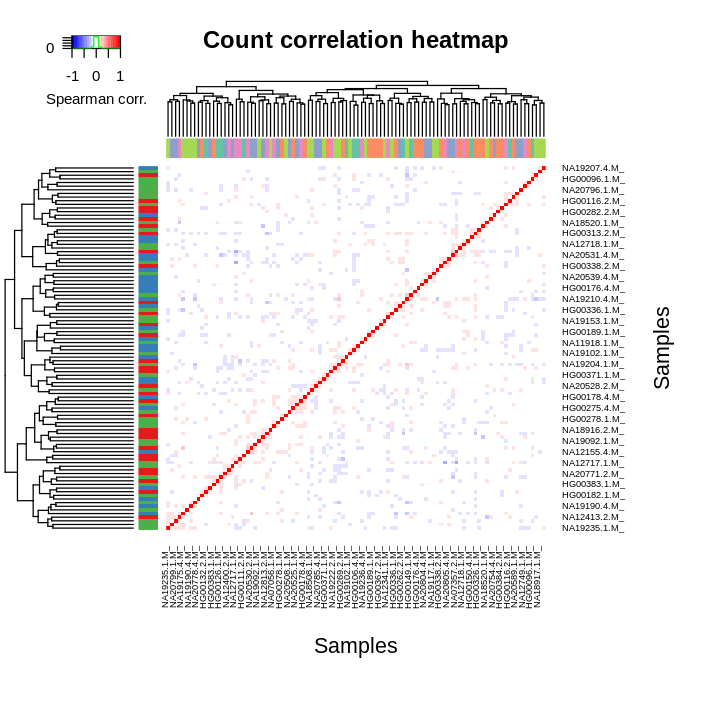

In [0]:
plotCountCorHeatmap(ods, colCoFactor="ORIGIN", rowCoFactor="LAB")

## Detection of expression outliers

After fitting the model, we obtain our expression outliers. But first, let's check how many expression outliers per sample were found.


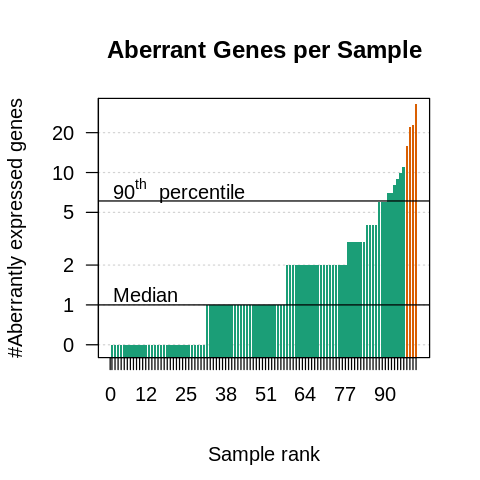

In [0]:
# make the plot again default size
options(repr.plot.width=4, repr.plot.height=4)

plotAberrantPerSample(ods)


Before we retrive the results we want to make sure that the gene IDs are understandable by humans. Hence, we use *biomaRt* to turn ENSEMBL gene IDs into HGNC symbols.

In [0]:
# load biomart 
library(biomaRt)
ensembl = useMart("ensembl", dataset = "hsapiens_gene_ensembl")

# remove versioning of gene IDs
geneIDs <- gsub("\\.[0-9]*(_[0-9]*)?.*$", "", rownames(ods))

# extract gene name mapping from ENSEMBL
genemap <- as.data.table(getBM(attributes=c("hgnc_symbol", "ensembl_gene_id"),
        filters="ensembl_gene_id", values=geneIDs, mart=ensembl))

head(genemap)
table(genemap$hgnc_symbol != "")

hgnc_symbol,ensembl_gene_id
<chr>,<chr>
DPM1,ENSG00000000419
SCYL3,ENSG00000000457
C1orf112,ENSG00000000460
FGR,ENSG00000000938
FUCA2,ENSG00000001036
GCLC,ENSG00000001084



FALSE  TRUE 
 1959 13564 

In [0]:
# merge rownames with gene map
map <- merge(data.table(ensembl_gene_id=geneIDs), genemap, all.x=TRUE)

# set new gene names only if hgnc symbol is present
mcols(ods)$ENSG <- geneIDs
rownames(ods) <- map[,ifelse(is.na(hgnc_symbol) | hgnc_symbol == "", geneIDs, hgnc_symbol)]

Now after fitting the model and having human readable gene names, we can finally retrieve our expression outliers using the *results* function.

In [0]:
res <- results(ods)
head(res)

geneID,sampleID,pValue,padjust,zScore,l2fc,rawcounts,normcounts,meanCorrected,theta,aberrant,AberrantBySample,AberrantByGene,padj_rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
ZNF549,NA12341.1.M_111124_5,2.809194e-20,4.489497e-15,-9.36,-4.90,4,5.46,203.27,32.65,TRUE,11,1,1
CAT,NA18873.4.M_120208_7,1.283159e-17,2.050673e-12,-9.18,-5.48,24,26.64,1238.03,14.33,TRUE,3,1,1
TIMMDC1,NA11918.1.M_111124_3,1.756748e-16,2.807537e-11,-8.53,-1.82,142,283.94,1001.53,79.26,TRUE,22,1,1
RTL8C,NA06984.1.M_111124_4,2.160870e-16,3.453382e-11,-8.73,-2.79,65,61.62,432.69,37.34,TRUE,33,1,1
PARP4,NA18916.2.M_111215_6,4.188343e-14,6.693577e-09,-8.16,-2.21,833,573.61,2646.43,39.62,TRUE,7,1,1
PKP4,NA12717.1.M_111124_3,1.301720e-13,2.080336e-08,-8.55,-4.81,6,24.06,771.31,15.91,TRUE,23,1,1


## Diagnosing a patient

We know that patient **NA18873.4.M_120208_7** has a rare mitochondrial disease with a complex-I deficiency. So we are looking for mitochondrial or complex-I related genes.

Lets have a look at a volcano plot. This shows the effect on x axis (Z-score) and the significance on the y axis (nominal P-value).

And also a closer look at the outliers of this case.

geneID,sampleID,pValue,padjust,zScore,l2fc,rawcounts,normcounts,meanCorrected,theta,aberrant,AberrantBySample,AberrantByGene,padj_rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
CAT,NA18873.4.M_120208_7,1.283159e-17,2.050673e-12,-9.18,-5.48,24,26.64,1238.03,14.33,TRUE,3,1,1
ENSG00000237513,NA18873.4.M_120208_7,3.442318e-07,2.750660e-02,-6.44,-4.97,0,0.00,42.23,12.88,TRUE,3,1,2
DCTD,NA18873.4.M_120208_7,8.540640e-07,4.549725e-02,-5.13,-0.46,1283,1515.38,2080.89,319.21,TRUE,3,1,3


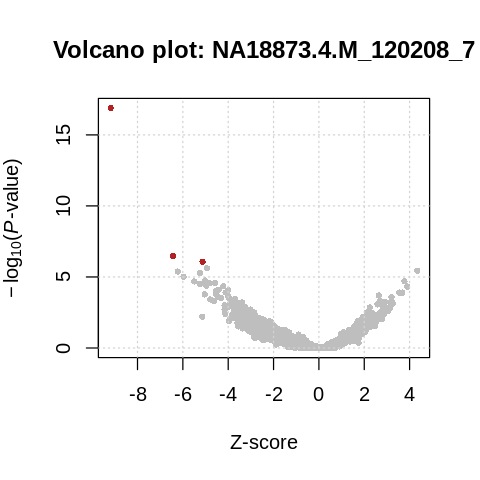

In [0]:
# TODO change injection to this sample: NA18873.4.M_120208_7
plotVolcano(ods, "NA18873.4.M_120208_7", base=TRUE)

# subset results for this patient
res[sampleID == "NA18873.4.M_120208_7"]

We do see 4 outliers in this case. But only one fits the phenotype.

* [CAT](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CAT) 
* [TIMMDC1](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TIMMDC1) 
* [ENSG00000237513](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ENSG00000237513) 
* [DCTD](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DCTD)

Lets have a closer look at on the gene level.

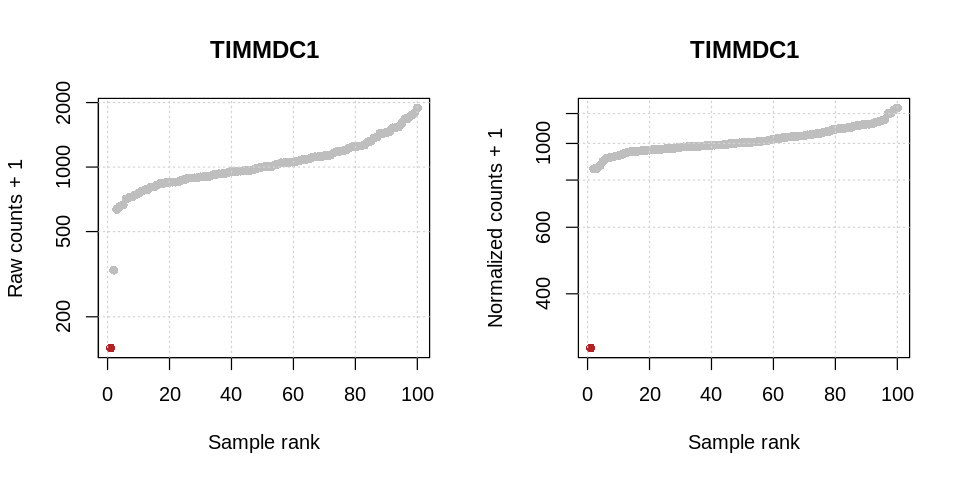

In [0]:
# make the plot again default size
options(repr.plot.width=8, repr.plot.height=4)

par(mfrow=c(1,2))
plotExpressionRank(ods, "TIMMDC1", norm=FALSE, basePlot=TRUE)
plotExpressionRank(ods, "TIMMDC1", norm=TRUE,  basePlot=TRUE)

To make sure also the fit was good and to investigate the test statistics, we can plot the quantile-quantile plot as well as the observed versus the expected gene expression.

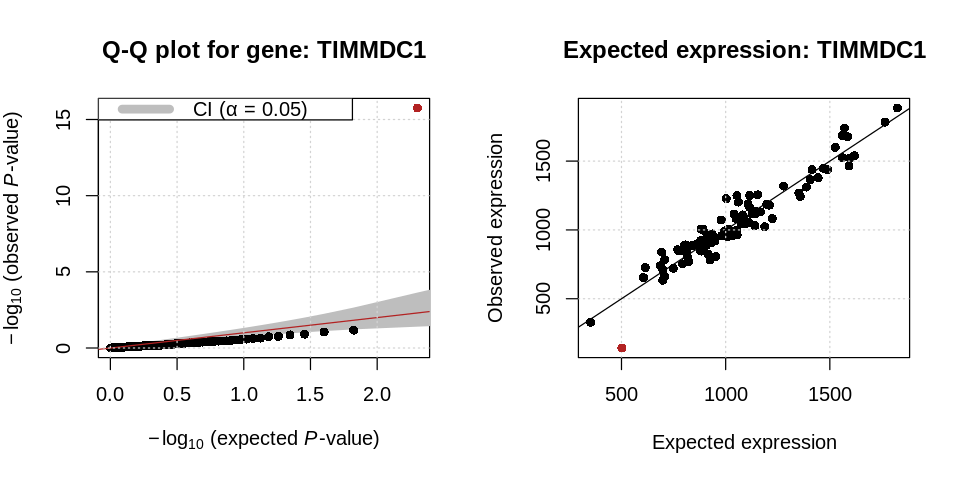

In [0]:
par(mfrow=c(1,2))

plotQQ(ods, "TIMMDC1")

# TODO: include this into the package as function
plot(normalizationFactors(ods)["TIMMDC1",], counts(ods)["TIMMDC1",], pch=16,
        main="Expected expression: TIMMDC1", ylab="Observed expression", 
        xlab="Expected expression");
grid()
abline(0,1)
points(pch=16, col="firebrick",
        normalizationFactors(ods)["TIMMDC1","NA11918.1.M_111124_3"], 
        counts(ods)["TIMMDC1","NA11918.1.M_111124_3"])


## What to do if you see many outliers?

NA11918.1.M_111124_3

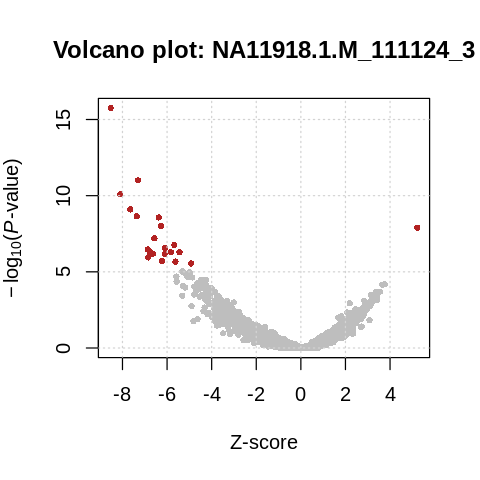

In [0]:
# make the plot again default size
options(repr.plot.width=4, repr.plot.height=4)

plotVolcano(ods, "NA11918.1.M_111124_3", base=TRUE)

In [0]:
# subset results for this patient
res[sampleID == "NA11918.1.M_111124_3"]

geneID,sampleID,pValue,padjust,zScore,l2fc,rawcounts,normcounts,meanCorrected,theta,aberrant,AberrantBySample,AberrantByGene,padj_rank
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
TIMMDC1,NA11918.1.M_111124_3,1.756748e-16,2.807537e-11,-8.53,-1.82,142,283.94,1001.53,79.26,TRUE,22,1,1.0
BRWD3,NA11918.1.M_111124_3,9.877570e-12,7.892891e-07,-7.30,-1.55,276,269.24,792.16,62.85,TRUE,22,1,2.0
PCED1B,NA11918.1.M_111124_3,8.120213e-11,4.325757e-06,-8.10,-6.76,1,1.15,251.35,7.76,TRUE,22,1,3.0
KLHL3,NA11918.1.M_111124_3,7.978297e-10,3.187617e-05,-7.65,-3.55,7,23.43,298.26,19.19,TRUE,22,1,4.0
PRKD3,NA11918.1.M_111124_3,2.234261e-09,7.141344e-05,-7.36,-4.34,31,46.16,991.92,9.54,TRUE,22,1,5.0
GOPC,NA11918.1.M_111124_3,2.695910e-09,7.180755e-05,-6.37,-0.82,511,650.17,1142.48,162.44,TRUE,22,1,6.0
DNMT3A,NA11918.1.M_111124_3,9.537390e-09,2.177447e-04,-6.27,-1.25,276,605.48,1434.63,66.21,TRUE,22,1,7.0
EEF1A1P4,NA11918.1.M_111124_3,1.290976e-08,2.578958e-04,5.22,0.90,3279,3897.74,2102.26,67.66,TRUE,22,1,8.0
GOLGA8A,NA11918.1.M_111124_3,6.276530e-08,1.114533e-03,-6.57,-3.44,124,200.35,2181.89,10.55,TRUE,22,1,9.0
